# **IBM Capstone Project **
Travel Agency Tour Recommendation

Levan Gvalia



**Introduction**

After enabling visa free entrance to EU from Georgia, in addition to introduction of cheap and popular
airlines, tourism abroad has become much more available to masses than It ever was. As an analyst at
Travel Agency, I clearly see result of visa free travel and cheap airlines – more people tend to favor
cheap and frequent travels.

The Travel Agency was focused on more expensive tours, with client tailored tour recommendations –
the information of which was gathered manually by employees, through online searches and word of
mouth. The problem is that, with recent changes, employees can’t keep up with the requests of cheaper
and more frequent travels, thus causing client churn rate to skyrocket. As company is not willing to give
up on its main advantage over competition – client tailored tour recommendations – as well as miss an
opportunity of cheap and frequent flights, some solution has to be offered.

**Business Problem**

So, this is where I come in – I plan to use Machine Learning and Location Data to cluster neighborhoods
depending on its venues on my own – the same process was previously done by several employees over several
days. The scope of the project is, that I have to prove eligibility of my offered tool on one popular travel
destination – Barcelona – if I am able to cluster neighborhoods appropriately, then management will
approve the tool which then will be used on other travel destinations.

**Data**

Combination of several sources will be the input data for the project:
1. Neighborhoods and PostCodes of Barcelona - will be collected manually and imported as a data source into the project
2. Latitude and Longitude of PostCodes – will be collected through arcgis of geocoder package
3. Venue Data of neighborhoods – Foursqueare API will be used to collect Points of Interest in proximity of Neighborhoods’ location

1. Neighborhoods and PostCodes of Barcelona 

I will use pandas read_excel function to import local file of Barcelona Neighborhood postal codes

In [1]:
import pandas as pd

In [2]:
file = "../input/capstoneproject/Barcelona Neighbourhoods v2.xlsx"
df = pd.read_excel(file)
df.head()

,PostCode,Neighborhood
0,8001,el Raval
1,8002,el Gòtic
2,8003,La Barceloneta
3,8004,el Poble-sec
4,8005,el Poblenou


As I am interested in more central parts of Barcelona, I will remove outskirts

In [3]:
df = df[~df['PostCode'].isin([8042, 8040,8039,8035,8033,8017])]


In [4]:
df.head()

,PostCode,Neighborhood
0,8001,el Raval
1,8002,el Gòtic
2,8003,La Barceloneta
3,8004,el Poble-sec
4,8005,el Poblenou


2. Latitude and Longitude of PostCodes

geocoder package will be used to determine latitudes and longitudes by postal codes of barcelona

In [5]:
import numpy as np

In [6]:
# for latitude and longitude of neighborhoods
!pip install geocoder
import geocoder 

     |████████████████████████████████| 98 kB 1.7 MB/s eta 0:00:011
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In order to get lat-long of postal codes I'll need - geocoder.arcgis('{}, Barcelona'.format(PostCode))- function, thus I define get_latlon(PostCode) function

In [7]:
#define function for lat long fetching
def get_latlon(PostCode):
    lat_lng_coords = None
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Barcelona'.format(PostCode))
        lat_lng_coords = g.latlng
        return lat_lng_coords 

Only thing remainig to get lat-longs, I have to iterate defined function over postal codes

In [8]:
#fetching lat long data
latlog = []
    
for i in df['PostCode']:
    a = get_latlon(i)
    latlog.append(a)
    


I'll merge fetched location data to my main dataframe

In [9]:
latlog = np.asarray(latlog)
df['Latitude'] = latlog[:,0]
df['Longitude'] = latlog[:,1]
#df_group.drop(['latitude','longitude'],axis=1,inplace=True)

In [10]:
df.head()

,PostCode,Neighborhood,Latitude,Longitude
0,8001,el Raval,41.380145,2.168721
1,8002,el Gòtic,41.382180,2.176718
2,8003,La Barceloneta,41.383205,2.187880
3,8004,el Poble-sec,41.370415,2.159972
4,8005,el Poblenou,41.396235,2.201622


Let's visualize for more visibility

In [11]:
#library for map visualization
import folium 

In [12]:
Barcelona_latitude = 41.3851
Barcelona_longitude = 2.1734

In [13]:
# create map
Barca_map = folium.Map(location=[Barcelona_latitude, Barcelona_longitude], zoom_start=12.5)


# add markers to the map
markers_colors = []
for lat, lon, zipcode in zip(df['Latitude'], df['Longitude'], df['PostCode']):
    label = folium.Popup(str(zipcode) , parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label
      ).add_to(Barca_map)
       
Barca_map

3. Venue Data of neighborhoods

In order to get venue data by lat-long, I'm using Foursuare API

In [14]:
import requests #foursqaure API to get data into json file
from pandas.io.json import json_normalize #get data from json file

Foursquare credentials will be hidden

limit of 100 venues in radius of 500 meters seems appropriate

In [16]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

I'll define function to get data of venues with requests.get call.

Venue names, location data but most importantly venue categories will be fetched 

In [17]:
#define function to get POIs
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        global url
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

I just have to run defined function for all postal codes

In [19]:
#get venue categories for nighborhoods
Barcelona_venues = getNearbyVenues(names=df['Neighborhood'],#[:14], #temp slicer                                   
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

el Raval
el Gòtic
La Barceloneta
el Poble-sec
el Poblenou
El Putget i Farró
Passeig de Gràcia (major metro stop)
l'Eixample
Dreta de l'Eixample
Sant Pere, Santa Caterina i la Ribera ('El Born')
Universitat (major metro stop)
Vila de Gràcia
Fort Pienc
Hostafrancs
la Nova Esquerra de l'Eixample
Porta
el Parc i la Llacuna del Poblenou
El Besòs i el Maresme
Sant Martí de Provençals
Sant Gervasi - Galvany
Sant Gervasi - la Bonanova
Vallvidrera, el Tibidabo i les Planes
la Salut
Sagrada Família
La Sagrera
la Maternitat i Sant Ramon
Les Corts
Sant Andreu de Palomar
Vilapicina i la Torre Llobeta
Horta
Pedralbes
L'Antiga Esquerra de l'Eixample
Camp d'en Grassot i Gràcia Nova
Montjuïc
la Marina de Port


In [20]:
Barcelona_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,el Raval,41.380145,2.168721,La Robadora,41.379500,2.170463,Gastropub
1,el Raval,41.380145,2.168721,Robadors 23,41.379581,2.170603,Jazz Club
2,el Raval,41.380145,2.168721,A Tu Bola,41.380096,2.169054,Tapas Restaurant
3,el Raval,41.380145,2.168721,33/45,41.381059,2.167399,Cocktail Bar
4,el Raval,41.380145,2.168721,Guixot,41.378509,2.167806,Spanish Restaurant


**Methodology**

Simple exploratory analysis of venue counts

In [21]:
Barcelona_venues.groupby('Neighborhood').Venue.count().reset_index().sort_values(by='Venue',ascending=False)

,Neighborhood,Venue
0,Camp d'en Grassot i Gràcia Nova,100
3,El Putget i Farró,100
4,Fort Pienc,100
7,L'Antiga Esquerra de l'Eixample,100
8,La Barceloneta,100
29,el Raval,100
25,el Gòtic,100
23,Vila de Gràcia,100
12,Passeig de Gràcia (major metro stop),100
20,"Sant Pere, Santa Caterina i la Ribera ('El Born')",100


As seen above more than half of neighborhoods have more than 50 venues listed. Thus I plan to sort venues as most common venue categories in its respective neighborhood and only consider top 10 venue categories per neighborhood, to make data more managable.

This kind of data seems perfect fit for k_means unsupervised clustering, in order to combine most related neighborhoods by top 10 venue categories. In order to find appropriate number of clusters I'll use elbow method. For these machine learning calculations I'll use scikit-learn package, which is well fitted for machine learning algorithms

Prepare for Analysis

In order to be able to cluster neighborhoods, I'll have to prepare data for analysis first. For that I'll use one hot encoding ensuring to get venue categories in columns and neighborhoods in rows

In [22]:
# one hot encoding
Barcelona_onehot = pd.get_dummies(Barcelona_venues[['Venue Category']], prefix="", prefix_sep="")
Barcelona_onehot['Neighborhood'] = Barcelona_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Barcelona_onehot.columns[-1]] + list(Barcelona_onehot.columns[:-1])
Barcelona_onehot = Barcelona_onehot[fixed_columns]

Barcelona_onehot.head()

,Zoo,Accessories Store,African Restaurant,American Restaurant,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,...,Venezuelan Restaurant,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Then I'll have to group neighborhoods and use mean aggregate function

In [23]:
Barcelona_groupby = Barcelona_onehot.groupby('Neighborhood').mean().reset_index()
Barcelona_groupby.head()

,Neighborhood,Zoo,Accessories Store,African Restaurant,American Restaurant,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,...,Venezuelan Restaurant,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio
0,Camp d'en Grassot i Gràcia Nova,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,...,0.0,0.0,0.0,0.0,0.01,0.020000,0.0,0.0,0.000000,0.01
1,Dreta de l'Eixample,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,...,0.0,0.0,0.0,0.0,0.00,0.019231,0.0,0.0,0.000000,0.00
2,El Besòs i el Maresme,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,...,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.011905,0.00
3,El Putget i Farró,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.02,0.0,...,0.0,0.0,0.0,0.0,0.00,0.040000,0.0,0.0,0.000000,0.00
4,Fort Pienc,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.02,0.0,...,0.0,0.0,0.0,0.0,0.00,0.010000,0.0,0.0,0.000000,0.00


Then I'll define function to get top 10 venue categories by neighborhoods

In [24]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [25]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Barcelona_groupby['Neighborhood']

for ind in np.arange(Barcelona_groupby.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Barcelona_groupby.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Camp d'en Grassot i Gràcia Nova,Mediterranean Restaurant,Restaurant,Italian Restaurant,Bakery,Tapas Restaurant,Hotel,Japanese Restaurant,Bar,Hostel,Café
1,Dreta de l'Eixample,Hostel,Hotel,Pizza Place,Tapas Restaurant,Coffee Shop,Restaurant,Spanish Restaurant,Beer Bar,Road,Café
2,El Besòs i el Maresme,Café,Hotel,Italian Restaurant,Diner,Restaurant,Clothing Store,Coffee Shop,Burger Joint,Mediterranean Restaurant,Juice Bar
3,El Putget i Farró,Mediterranean Restaurant,Café,Hotel,Bakery,Pizza Place,Wine Bar,Japanese Restaurant,Italian Restaurant,Grocery Store,Restaurant
4,Fort Pienc,Restaurant,Café,Spanish Restaurant,Hotel,Mexican Restaurant,Grocery Store,Tapas Restaurant,Bed & Breakfast,Italian Restaurant,Bakery


Analysis

In order to find appropriate number of K-means, I'll use elbow method

In [26]:
#libraries for clustering
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

#library for map
import matplotlib.pyplot as plt

In [27]:
Barcelona_clustering = Barcelona_groupby.drop('Neighborhood', 1)

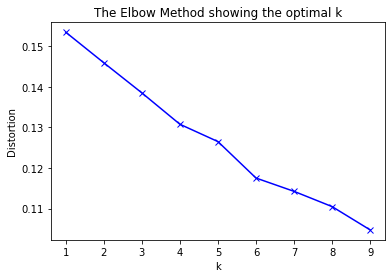

In [28]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(Barcelona_clustering)
    kmeanModel.fit(Barcelona_clustering)
    distortions.append(sum(np.min(cdist(Barcelona_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / Barcelona_clustering.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

according to elbow method, optimal k can be set at 6

kmeans 

In [29]:
# set number of clusters
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Barcelona_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 4, 2, 2, 2, 1, 1, 1, 1, 5], dtype=int32)

Cluster labels will be added back to dataframe, as neighborhoods were removed before not to interfere with k-means algorithms

In [30]:
#neighborhoods_venues_sorted = neighborhoods_venues_sorted.drop('Cluster Labels',axis=1)

In [31]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
Barcelona_merged = df#[:14] #temp slicer
Barcelona_merged = Barcelona_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')


Barcelona_merged.head() 

,PostCode,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,8001,el Raval,41.380145,2.168721,1,Spanish Restaurant,Mediterranean Restaurant,Tapas Restaurant,Cocktail Bar,Pizza Place,Plaza,Bar,Hotel,Bookstore,Donut Shop
1,8002,el Gòtic,41.382180,2.176718,1,Tapas Restaurant,Spanish Restaurant,Plaza,Hotel,Ice Cream Shop,Italian Restaurant,Mediterranean Restaurant,Wine Bar,Bar,Coffee Shop
2,8003,La Barceloneta,41.383205,2.187880,1,Tapas Restaurant,Bar,Seafood Restaurant,Mediterranean Restaurant,Spanish Restaurant,Ice Cream Shop,Burger Joint,Restaurant,Hotel,Food & Drink Shop
3,8004,el Poble-sec,41.370415,2.159972,1,Mediterranean Restaurant,Pizza Place,Park,Theater,Restaurant,Plaza,Spanish Restaurant,Brewery,Tapas Restaurant,Palace
4,8005,el Poblenou,41.396235,2.201622,1,Beach Bar,Spanish Restaurant,Tapas Restaurant,Mediterranean Restaurant,Gastropub,Bakery,Vegetarian / Vegan Restaurant,Restaurant,Pizza Place,Ice Cream Shop


**Results** & **Discussion**

now we have results and we'll have to dive into it to make conclusions.
first I'll start with visualization and then check check results by cluster labels.

Visualization

for visualization I'll use folium map, which will help us have clear view of the results

In [32]:
#libraries for visualization
import matplotlib.cm as cm
import matplotlib.colors as colors

I'll start by zooming in to barcelona and highlighting clusters with its respective colors

In [33]:
# create map
map_clusters = folium.Map(location=[Barcelona_latitude, Barcelona_longitude], zoom_start=12.5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Barcelona_merged['Latitude'], Barcelona_merged['Longitude'], Barcelona_merged['Neighborhood'], Barcelona_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

as it seems clusters 1 & 2 occupy most of the city map, more concentrated in city center and scattered around the city too

Cluster 5 is third most common of the clusters and is mostly located around the uptown of the city

Cluster 4 is located across the city center, but takes less impressive count of locations spots.

Cluster 3 seems to be concentrated in more outskirts of the city

Cluster 0 seems to be outlier in terms of map occupation, but it might be interesting to check this in more details

Clusters

Next I'll take a look at clusters by its most common venue categories.
It would be interesting to check each by each.

In [34]:
Barcelona_merged.loc[Barcelona_merged['Cluster Labels'] == 0, Barcelona_merged.columns[[0] + list(range(4, Barcelona_merged.shape[1]))]]

,PostCode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
32,8034,0,Park,Tennis Court,Plaza,Mediterranean Restaurant,Garden,Spanish Restaurant,Church,Trail,Gym / Fitness Center,College Cafeteria
36,8038,0,Stadium,Plaza,Park,Baseball Stadium,Gym / Fitness Center,Skate Park,Hill,Garden,Basketball Stadium,Hot Dog Joint


In [35]:
Barcelona_merged.loc[Barcelona_merged['Cluster Labels'] == 1, Barcelona_merged.columns[[0] + list(range(4, Barcelona_merged.shape[1]))]]

,PostCode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,8001,1,Spanish Restaurant,Mediterranean Restaurant,Tapas Restaurant,Cocktail Bar,Pizza Place,Plaza,Bar,Hotel,Bookstore,Donut Shop
1,8002,1,Tapas Restaurant,Spanish Restaurant,Plaza,Hotel,Ice Cream Shop,Italian Restaurant,Mediterranean Restaurant,Wine Bar,Bar,Coffee Shop
2,8003,1,Tapas Restaurant,Bar,Seafood Restaurant,Mediterranean Restaurant,Spanish Restaurant,Ice Cream Shop,Burger Joint,Restaurant,Hotel,Food & Drink Shop
3,8004,1,Mediterranean Restaurant,Pizza Place,Park,Theater,Restaurant,Plaza,Spanish Restaurant,Brewery,Tapas Restaurant,Palace
4,8005,1,Beach Bar,Spanish Restaurant,Tapas Restaurant,Mediterranean Restaurant,Gastropub,Bakery,Vegetarian / Vegan Restaurant,Restaurant,Pizza Place,Ice Cream Shop
10,8011,1,Café,Mediterranean Restaurant,Tapas Restaurant,Dessert Shop,Japanese Restaurant,Bakery,Coffee Shop,Spanish Restaurant,Cocktail Bar,Argentinian Restaurant
11,8012,1,Plaza,Mediterranean Restaurant,Bar,Tapas Restaurant,Pizza Place,Arts & Crafts Store,Restaurant,Ice Cream Shop,Café,Cocktail Bar
13,8014,1,Tapas Restaurant,Bar,Wine Bar,Mediterranean Restaurant,Italian Restaurant,Middle Eastern Restaurant,Hotel,Pie Shop,Pizza Place,Plaza
30,8032,1,Spanish Restaurant,Tapas Restaurant,Restaurant,Pub,Food & Drink Shop,Pedestrian Plaza,Sandwich Place,Supermarket,Café,Bakery
34,8036,1,Spanish Restaurant,Hotel,Tapas Restaurant,Restaurant,Cocktail Bar,Japanese Restaurant,Mediterranean Restaurant,Bakery,Pizza Place,Seafood Restaurant


In [36]:
Barcelona_merged.loc[Barcelona_merged['Cluster Labels'] == 2, Barcelona_merged.columns[[0] + list(range(4, Barcelona_merged.shape[1]))]]

,PostCode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,8006,2,Mediterranean Restaurant,Café,Hotel,Bakery,Pizza Place,Wine Bar,Japanese Restaurant,Italian Restaurant,Grocery Store,Restaurant
12,8013,2,Restaurant,Café,Spanish Restaurant,Hotel,Mexican Restaurant,Grocery Store,Tapas Restaurant,Bed & Breakfast,Italian Restaurant,Bakery
14,8015,2,Restaurant,Hotel,Japanese Restaurant,Café,Mediterranean Restaurant,Coffee Shop,Peruvian Restaurant,Tapas Restaurant,Wine Bar,Brewery
17,8018,2,Hotel,Japanese Restaurant,Spanish Restaurant,Restaurant,Mediterranean Restaurant,Art Museum,Plaza,Supermarket,Bistro,Breakfast Spot
18,8019,2,Café,Hotel,Italian Restaurant,Diner,Restaurant,Clothing Store,Coffee Shop,Burger Joint,Mediterranean Restaurant,Juice Bar
27,8029,2,Mediterranean Restaurant,Restaurant,Café,Japanese Restaurant,Brewery,Italian Restaurant,Bakery,Burger Joint,Coffee Shop,Paella Restaurant
35,8037,2,Mediterranean Restaurant,Restaurant,Italian Restaurant,Bakery,Tapas Restaurant,Hotel,Japanese Restaurant,Bar,Hostel,Café
40,8075,2,Restaurant,Mediterranean Restaurant,Burger Joint,Pizza Place,Café,Japanese Restaurant,Spanish Restaurant,Bakery,Latin American Restaurant,Train Station


In [37]:
Barcelona_merged.loc[Barcelona_merged['Cluster Labels'] == 3, Barcelona_merged.columns[[0] + list(range(4, Barcelona_merged.shape[1]))]]

,PostCode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,8016,3,Tapas Restaurant,Supermarket,Plaza,Spanish Restaurant,Sandwich Place,Department Store,Restaurant,Park,Clothing Store,Public Art
19,8020,3,Tapas Restaurant,Coffee Shop,Supermarket,Grocery Store,Bakery,Food,Pizza Place,Spanish Restaurant,Burger Joint,Fast Food Restaurant
29,8031,3,Tapas Restaurant,Spanish Restaurant,Pizza Place,Sandwich Place,Café,Burger Joint,Pub,Restaurant,Coffee Shop,Basketball Stadium


In [38]:
Barcelona_merged.loc[Barcelona_merged['Cluster Labels'] == 4, Barcelona_merged.columns[[0] + list(range(4, Barcelona_merged.shape[1]))]]

,PostCode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,8007,4,Hotel,Clothing Store,Tapas Restaurant,Hostel,Spanish Restaurant,Cocktail Bar,Mediterranean Restaurant,Bookstore,Cosmetics Shop,Furniture / Home Store
7,8008,4,Cocktail Bar,Hotel,Bakery,Mediterranean Restaurant,Boutique,Art Gallery,Hostel,Bookstore,Clothing Store,Restaurant
8,8009,4,Hostel,Hotel,Pizza Place,Tapas Restaurant,Coffee Shop,Restaurant,Spanish Restaurant,Beer Bar,Road,Café
9,8010,4,Hotel,Hostel,Tapas Restaurant,Coffee Shop,Spanish Restaurant,Bookstore,Bistro,Burger Joint,Café,Breakfast Spot


In [39]:
Barcelona_merged.loc[Barcelona_merged['Cluster Labels'] == 5, Barcelona_merged.columns[[0] + list(range(4, Barcelona_merged.shape[1]))]]

,PostCode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,8021,5,Deli / Bodega,Italian Restaurant,Mediterranean Restaurant,Bakery,Spanish Restaurant,Grocery Store,Hotel,Coffee Shop,Sandwich Place,Burger Joint
21,8022,5,Bakery,Seafood Restaurant,Spanish Restaurant,Mediterranean Restaurant,Plaza,Japanese Restaurant,Breakfast Spot,Bar,Grocery Store,Café
22,8023,5,Café,Bakery,Hotel,Burger Joint,Supermarket,Park,Grocery Store,IT Services,Gym,Spanish Restaurant
23,8024,5,Bar,Mediterranean Restaurant,Restaurant,Tapas Restaurant,Spanish Restaurant,Historic Site,Hotel,Park,Supermarket,Café
24,8025,5,Hotel,Bakery,Spanish Restaurant,Bar,Mexican Restaurant,Italian Restaurant,Restaurant,Supermarket,Coffee Shop,Toy / Game Store
25,8027,5,Supermarket,Grocery Store,Bakery,Plaza,Spanish Restaurant,Diner,Restaurant,Bar,Pizza Place,Falafel Restaurant
26,8028,5,Pizza Place,Soccer Stadium,Café,Bar,Bakery,Supermarket,Tapas Restaurant,Coffee Shop,Sandwich Place,Museum
28,8030,5,Clothing Store,Burger Joint,Spanish Restaurant,Tapas Restaurant,Fast Food Restaurant,Electronics Store,Sandwich Place,Women's Store,Supermarket,Café


It is already possible to make assumptions from this view, but I prefer to add sorted counts of venue categories by neighborhoods, which in addition to map visual, should give clearer view

In order to add sorted view of venue categories, I merge cluster data with venue list and check counts of venues per neighborhood per venue category

In [40]:
Cluster_data = neighborhoods_venues_sorted[['Neighborhood','Cluster Labels']].groupby(['Neighborhood','Cluster Labels']).count()
Cluster_data.head()

,
Neighborhood,Cluster Labels
Camp d'en Grassot i Gràcia Nova,2
Dreta de l'Eixample,4
El Besòs i el Maresme,2
El Putget i Farró,2
Fort Pienc,2


In [41]:
Clusters_Merged = Cluster_data.join(Barcelona_venues.set_index('Neighborhood'), on='Neighborhood')
Clusters_Merged.head()

Neighborhood Latitude  \
Neighborhood                    Cluster Labels                          
Camp d'en Grassot i Gràcia Nova 2                           41.400148   
                                2                           41.400148   
                                2                           41.400148   
                                2                           41.400148   
                                2                           41.400148   

                                                Neighborhood Longitude  \
Neighborhood                    Cluster Labels                           
Camp d'en Grassot i Gràcia Nova 2                             2.165735   
                                2                             2.165735   
                                2                             2.165735   
                                2                             2.165735   
                                2                             2.165735   

                                                                Venue  \
Neighborhood                    Cluster Labels                          
Camp d'en Grassot i Gràcia Nova 2               Yeah Hostel Barcelona   
                                2               Microteatre Barcelona   
                                2                               Origo   
                                2                       Ramen-Ya Hiro   
                                2                           Can Kenji   

                                                Venue Latitude  \
Neighborhood                    Cluster Labels                   
Camp d'en Grassot i Gràcia Nova 2                    41.400001   
                                2                    41.401578   
                                2                    41.400517   
                                2                    41.399643   
                                2                    41.400340   

                                                Venue Longitude  \
Neighborhood                    Cluster Labels                    
Camp d'en Grassot i Gràcia Nova 2                      2.164401   
                                2                      2.164577   
                                2                      2.163144   
                                2                      2.164738   
                                2                      2.166340   

                                                     Venue Category  
Neighborhood                    Cluster Labels                       
Camp d'en Grassot i Gràcia Nova 2                            Hostel  
                                2                     Indie Theater  
                                2                            Bakery  
                                2                  Ramen Restaurant  
                                2               Japanese Restaurant

In [42]:
Clusters_sorted = Clusters_Merged.groupby(['Cluster Labels', 'Venue Category']).Venue.count().reset_index().sort_values(by=['Cluster Labels','Venue'],ascending=False)
Clusters_sorted.head()

,Cluster Labels,Venue Category,Venue
503,5,Bakery,23
603,5,Spanish Restaurant,22
606,5,Supermarket,18
550,5,Grocery Store,17
558,5,Hotel,17


In [43]:
Clusters_sorted[Clusters_sorted['Cluster Labels']==1].head(5)

,Cluster Labels,Venue Category,Venue
169,1,Tapas Restaurant,59
162,1,Spanish Restaurant,47
115,1,Mediterranean Restaurant,44
35,1,Bar,29
96,1,Hotel,25


In [44]:
Clusters_sorted[Clusters_sorted['Cluster Labels']==2].head(5)

,Cluster Labels,Venue Category,Venue
303,2,Restaurant,40
256,2,Hotel,37
213,2,Café,35
275,2,Mediterranean Restaurant,35
264,2,Italian Restaurant,22


In [45]:
Clusters_sorted[Clusters_sorted['Cluster Labels']==3].head(5)

,Cluster Labels,Venue Category,Venue
388,3,Tapas Restaurant,14
385,3,Spanish Restaurant,7
387,3,Supermarket,7
376,3,Pizza Place,6
354,3,Coffee Shop,5


In [46]:
Clusters_sorted[Clusters_sorted['Cluster Labels']==4].head(5)

,Cluster Labels,Venue Category,Venue
444,4,Hotel,47
443,4,Hostel,20
486,4,Tapas Restaurant,14
417,4,Cocktail Bar,13
481,4,Spanish Restaurant,12


In [47]:
Clusters_sorted[Clusters_sorted['Cluster Labels']==5].head(5)

,Cluster Labels,Venue Category,Venue
503,5,Bakery,23
603,5,Spanish Restaurant,22
606,5,Supermarket,18
550,5,Grocery Store,17
558,5,Hotel,17


Now we are ready to discuss results and make assumptions

Sorting of the venue categories strengthened my opinions about clusters
1. As it seems Cluster 1 is more concentrated around Tapas restaurant, which is specialty of Barcelona and Spain itself. It should be interesting location for tourist to check in, while traveling to Barcelona, to taste local cuisine 
2. Cluster 2 seems to be focused more on internation food, then local cuisine. This might seem interesting for tourists, as they might be interested in tasting other foods too, after trying out local cuisine. Mediteranian food seems more frequent in addition to Italiat food and some Japanese restaurants. 
3. Cluster 4 has higher concentration of hotels/hostels, which should be interesting info for tourist who is in search of hotels, or trying to avoid places with high concentration of hotels
4. Cluster 5 seems to be more residential cluster, as grocery shops and supermarkets have higher count. This seems to be less interseting locations, but some specific tourists want check residential areas of city and not only touristic places, to feel real city vibe.
5. Cluster 0 seems to be concentrated on sport activities, for those who want to take a break from local or international cuisine tasting and lose several calories on the way, or just relax.
6. Cluster 3 does not seem to be of particular interest as it does now show any trend of particular places. As seen on the map, this cluster is located in less central areas of the city.

**Conclusion**

As I mentioned in the introduction, whole point of this project is to prove machine learning capabilities for location/neighborhood auto recommendation to customers. All the steps executed required little human intervention and this method can be used for other locations too. 

There is space for improvement, of course. Other machine learning algorithms can be added for getting better results. Or algorithms can be tailored for individual or specific groups of customers, who are more interested in some particular areas of tourism. 

Also some human interactions can be reduced too. As I used local file for Barcelona districts, web scrapping can be incorporated in this part. Also paid features of Foursquare API can be used to enhance venue data to better fit needs.

Decision should be made bt stakeholders, but to me this method is out of competition. Still it won't be easy to prove to stakeholders, but with some other locations and imprivements mentioned above succes should be easily achieved